In [2]:
import pandas as pd
import os
import torch
from transformers import Trainer, BertTokenizer
import numpy as np


os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")

test_sentences_verbs = pd.read_csv("Datasets/nutids-r-reviewed.csv", sep="|")

In [3]:
correct_sentences = test_sentences_verbs["correct"].values
correct_sentences[:2]

array(['Det er ikke altid nemt at forsvare din opførsel',
       'Mange drenge interesserer sig for fodbold'], dtype=object)

In [4]:
import pickle
import stanza
from tqdm import tqdm

def get_pos(x):
    with open("FineTuneModels/pos_caching.pkl", "rb") as f:
        pos_list = pickle.load(f)
    if len(pos_list) != len(x):
        pos_list = []
        pos_tagger = stanza.Pipeline("da", processors='tokenize,pos', use_gpu=True, cache_directory='./cache', tokenize_pretokenized=True, n_process=4)
        for sentence in tqdm(x):
            pos = get_pos_tags(sentence, pos_tagger)
            pos_list.append(pos)
        print(len(pos_list))
        print("Updating")
        with open("FineTuneModels/pos_caching.pkl", "wb") as f:
            pickle.dump(pos_list, f)
        print("Updated")
    else:
        print("pos_caching.pkl already exists")
    return pos_list

def get_pos_tags(sentence, pos_tagger):
    doc = pos_tagger(sentence)
    features = [word.feats if word.feats else None for sentence in doc.sentences for word in sentence.words]
    feature_dicts = turn_features_to_dicts(features)
    results = [(word.upos, [word.start_char, word.end_char], feature_dicts[i]) for sentence in doc.sentences for i, word in enumerate(sentence.words)]
    return results

def turn_features_to_dicts(features):
    feature_dicts = []
    current_tense = None
    for feature in features:
        if feature is None:
            feature_dicts.append({})
            continue
        feature_dict = {}
        current_features = feature.split("|")
        for current_feature in current_features:
            key, value = current_feature.split("=")
            if key == "Tense" and current_tense is None:
                current_tense = value
            feature_dict[key] = value
        if "Tense" not in feature_dict and "VerbForm" in feature_dict and key is not None:
            feature_dict["Tense"] = "Pres" if current_tense is None else current_tense
        feature_dicts.append(feature_dict)
    return feature_dicts

all_pos = get_pos(correct_sentences)

pos_caching.pkl already exists


In [5]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "europarl-v7.da-en.da"
with open(filename, "r", encoding="UTF-8") as file:
    lines = file.readlines()
with open("nutids_r_bøjninger.pickle", "rb") as f:
    nutids_r_bøjninger = pickle.load(f)
with open("nutids_r_stem.pickle", "rb") as f:
    nutids_r_stem = pickle.load(f)

In [6]:
from tqdm import tqdm

testset = []
labels = []

padded_words = []

padding_left = 10
padding_right = 4

def get_pos_tags(index):
    current_pos = all_pos[index]
    return [current_pos[i][0] for i in range(len(current_pos))]

og_index = 0

for i in tqdm(range(len(correct_sentences))):
    line = correct_sentences[i]
    if len(str(line)) < 1 or str(line) == "nan":
        continue
    line = line.strip("\n")
    true_words = line.split()
    pos = get_pos_tags(i)
    words = ["<PAD>"]*padding_left + pos + ["<PAD>"]*padding_right
    true_padded_words = ["<PAD>"]*padding_left + true_words + ["<PAD>"]*padding_right
    for i, word in enumerate(true_words):
        try: stemmed = nutids_r_stem[word]
        except: continue
        if word[-1] == "s" or words[i+padding_left] != "VERB":
            continue
        if true_words[i-1].lower().strip() == "og": 
            og_index += 1
            continue
        if nutids_r_bøjninger[stemmed][0] == word:
            labels.append(1)
        else:
            labels.append(0)
        testset.append(" ".join(words[i:i+padding_left+padding_right+1]))
        padded_words.append(" ".join(true_padded_words[i:i+padding_left+padding_right+1]))

100%|██████████| 240/240 [00:00<00:00, 40226.70it/s]


In [7]:
og_index

32

In [8]:
df = pd.DataFrame(zip(testset, labels), columns=["comment_text", "label"])
print("Test size: ", len(df))
print("Label distribution: ")
df["label"].value_counts()

Test size:  360
Label distribution: 


0    210
1    150
Name: label, dtype: int64

In [9]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")
model_path = "FineTuneModels/models/nutidsrModel7-BERT"
model_name = "Model 7-BERT"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

def load_model(path):
    device = "mps"
    torch.device(device)
    classifier = torch.load(path, map_location=torch.device('cpu'))
    classifier.eval()
    classifier.to(device)
    return Trainer(classifier)


model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained('Maltehb/danish-bert-botxo')

def convert_dataset_to_dataloader(dataset):
    test_dataset = Dataset(dataset)
    return test_dataset

def tokenize_sentences(sentences):
    X_tokenized = tokenizer(sentences, padding=True, truncation=True)
    return X_tokenized

def get_predictions(dataloader):
    raw_predictions, _, _ = model.predict(dataloader)
    scores = torch.softmax(torch.from_numpy(raw_predictions), dim=1)
    max_scores, final_prediction = torch.max(scores, dim=1)
    final_prediction = np.argmax(raw_predictions, axis=1)
    return [(p, s) for p, s in zip(final_prediction, max_scores)]


def verbs_to_check(words, pos):
    pos = pos
    verbs = []
    for i in range(len(pos)):
        if pos[i][0] != "VERB":
            verbs.append(False)
        elif "Tense" not in pos[i][2].keys():
            verbs.append(False)
        elif pos[i][2]["Tense"] != "Pres":
            verbs.append(False)
        else:
            verbs.append(True)
    for i, bool in enumerate(verbs):
        if not bool:
            continue
        word = words[i].strip(",.!?():;")
        try: stemmed_verb = nutids_r_stem[word]
        except: verbs[i] = False; continue
    return verbs

tokenized = tokenize_sentences(testset)
dataloader = convert_dataset_to_dataloader(tokenized)
predictions = get_predictions(dataloader)

  0%|          | 0/45 [00:00<?, ?it/s]

In [12]:
true_predictions = [p for (p, s) in predictions]
true_score = [s for (p, s) in predictions]

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(labels, true_predictions)
precision = precision_score(labels, true_predictions)
recall = recall_score(labels, true_predictions)
f1 = f1_score(labels, true_predictions)

data = {
    'Evaluation Measure': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
df = pd.DataFrame(data)

print(df)

  Evaluation Measure     Value
0           Accuracy  0.988889
1          Precision  1.000000
2             Recall  0.973333
3           F1 Score  0.986486


Accuracy before disqualifying "og: 97.8%

Accuracy after disqualifying "og": 98.9%

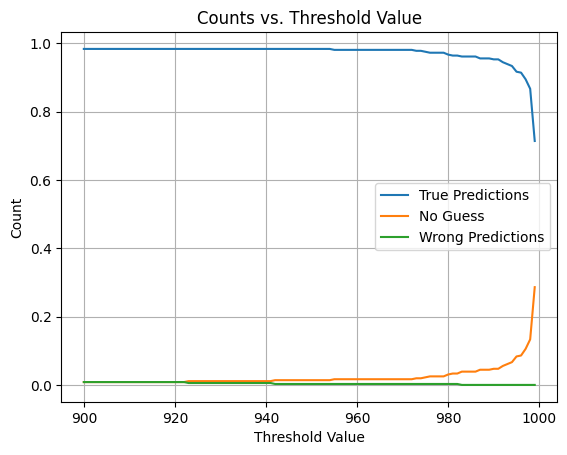

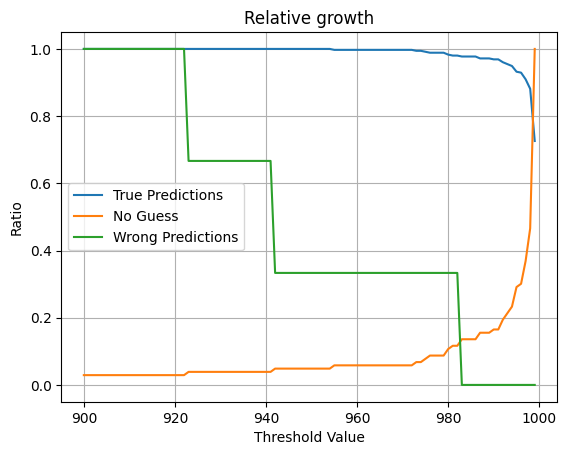

In [22]:
import matplotlib.pyplot as plt

def test_cutoff(value):
    new_predictions = [p if s > value else None for (p, s) in predictions]
    true = sum([1 if p == t else 0 for (p, t) in zip(new_predictions, labels)])
    no_guess = sum([1 if p is None else 0 for p in new_predictions])
    wrong = sum([1 if p != t and p is not None else 0 for (p, t) in zip(new_predictions, labels)])
    return true/len(labels), no_guess/len(labels), wrong/len(labels)

def test_all_values():
    values = range(900, 1000)
    trues, no_guesss, wrongs = [], [], []
    for value in values:
        true, no_guess, wrong = test_cutoff(value/1000)
        trues.append(true)
        no_guesss.append(no_guess)
        wrongs.append(wrong)

    for i in range(len(values)):
        if trues[i] + no_guesss[i] + wrongs[i] > 1:
            print(trues[i], no_guesss[i], wrongs[i])

    max_true = max(trues)
    max_no_guess = max(no_guesss)
    max_wrong = max(wrongs)

    plt.plot(values, trues, label='True Predictions')
    plt.plot(values, no_guesss, label='No Guess')
    plt.plot(values, wrongs, label='Wrong Predictions')

    plt.xlabel('Threshold Value')
    plt.ylabel('Count')
    plt.title('Counts vs. Threshold Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(values, [x/max_true for x in trues], label='True Predictions')
    plt.plot(values, [x/max_no_guess for x in no_guesss], label='No Guess')
    plt.plot(values, [x/max_wrong for x in wrongs], label='Wrong Predictions')
    plt.xlabel('Threshold Value')
    plt.ylabel('Ratio')
    plt.title('Relative growth')
    plt.legend()
    plt.grid(True)
    plt.show()

test_all_values()
    


In [32]:
from tabulate import tabulate


table_data = [
    ("0.50", test_cutoff(0.50)),
    ("0.90", test_cutoff(0.90)),
    ("0.98", test_cutoff(0.98)),
    ("0.99", test_cutoff(0.99)),
    ("0.995", test_cutoff(0.995)),
    ("0.999", test_cutoff(0.999)),

]

for i, (value, (true, no_guess, wrong)) in enumerate(table_data):
    true_percentage = round(true*100, 2)
    no_guess_percentage = round(no_guess*100, 2)
    wrong_percentage = round(wrong*100, 2)
    table_data[i] = (value, (true_percentage, no_guess_percentage, wrong_percentage))

# Create the table
table = []
headers = ["Cutoff", "Correct (%)", "No Guess (%)", "Wrong (%)"]

for data in table_data:
    row = [data[0]] + list(data[1])
    table.append(row)

# Generate the table using tabulate
table_str = tabulate(table, headers, tablefmt="pipe")

# Print the table
print(table_str)


|   Cutoff |   Correct (%) |   No Guess (%) |   Wrong (%) |
|---------:|--------------:|---------------:|------------:|
|    0.5   |         98.89 |           0    |        1.11 |
|    0.9   |         98.33 |           0.83 |        0.83 |
|    0.98  |         96.67 |           3.06 |        0.28 |
|    0.99  |         95.28 |           4.72 |        0    |
|    0.995 |         91.67 |           8.33 |        0    |
|    0.999 |         71.39 |          28.61 |        0    |


## Error display:

In [19]:
errors_index = [True if p != t else False for (p, t) in zip(true_predictions, labels)]
errors = [padded_words[i] for i in range(len(padded_words)) if errors_index[i]]
print(*errors, sep="\n\n")

programmer til beskyttelse af barentsee, og derfor beder jeg dem gennemgå et brevudkast, som beskriver

for det sker af og til, at man lader sig repræsentere <PAD> <PAD> <PAD> <PAD>

<PAD> Så næste gang du har brug for en pause, gå ind i parken, ånd

gå ind i parken, ånd dybt og lad naturens skønhed omfavne dig <PAD> <PAD> <PAD>
